# AR (Autoregressive) Model

AR(p) (AutoRegressive of order p)는 간단하게 과거의 패턴이 지속된다면 <br>
시계열 데이터 관측치 $ y_t $ 는 과거 관측치 $ y_{t-1} $, $ y_{t-2} $, $ y_{t-3} $, ... 에 의해 예측될 수 있다고 봅니다. <br>
오직 과거의 데이터(lagged variables)만 사용해서 예측 모형을 만들게 되며, 이름도 autoregressive 입니다. (그리스어로 auto 라는 뜻은 "self"를 가르킵니다.)<br>



$$ \begin{align}
X_t &= \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + c  \\
&= c + \sum^p_{i=1} \alpha_i X_{t-i} + \epsilon_t
\end{align}$$ 

* **order:** $ p $ 는 모델에서 사용된 lagged variables의 갯수
* **parameters (coefficients):** $ \alpha_1 $, $ \alpha_2 $, ..., $ \alpha_p $
* **error term (white noise):** $ \epsilon_t $

즉 time lag operator를 사용하면 다음과 같이 공식을 세울 수 있습니다.<br>
그리고 아래의 notation은 ARMA (autoregressive moving average)와 동일합니다.

$$ \left( 1 - \sum^p_{k=1} \alpha_k L^k \right) X_t = \epsilon_t $$

이때 다음과 같은 조건들을 갖습니다.

$$ \begin{align} 
|\alpha| &< 1 \\
Var[X_t] &= \frac{\sigma^2}{1-\sigma^2}
\end{align} $$

예를 들어서 order $ p $ 값이 2인 AR(2) 를 구하면 다음과 같습니다.

$$ x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} + \epsilon_t  $$


> <span style="color:red;"> AR은 일반적으로 t+7 정도밖에 예측을 못합니다. <br>
> 데이터에 따라서 다르지만, 실전에 들어가면 워낙 랜덤한 부분이 많아서 제대로 예측을 못합니다.

## Configuration

In [1]:
LAG = 12

## Import


In [2]:
%pylab inline
import math
import pandas as pd

from statsmodels.tsa.ar_model import AR
from statsmodels import api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from data import get_data
from tool import show_result

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data

            passenger
1949-01-01      112.0
1949-02-01      118.0
1949-03-01      132.0
1949-04-01      129.0
1949-05-01      121.0

train: (100,)
test: (44,)
ts_train: (100, 12)
ts_test: (32, 12)


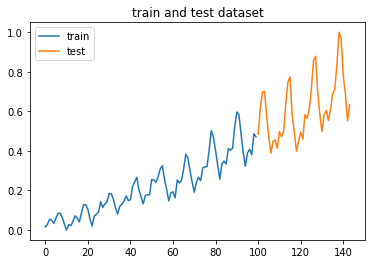

In [14]:
filename = 'dataset/international-airline-passengers.csv'
dataframe, train, test, ts_train, ts_test = get_data(filename, LAG, normalize=True)

print(dataframe.head())
print()
print('train:', train.shape)
print('test:', test.shape)
print('ts_train:', ts_train.shape)
print('ts_test:', ts_test.shape)


plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

## Code in statsmodels

Params: [ 0.02168137  0.44647819 -0.23253235  0.19711385 -0.23403005  0.22467793
 -0.14901898  0.10859823 -0.21299478  0.2390538  -0.2296759   0.32999109
  0.60970666]
Lag Value: 12
Train R^2: 0.974706153551
Train MSE: 0.00353389283816
Test  R^2: 0.381145522893
Test  MSE: 0.01347857397


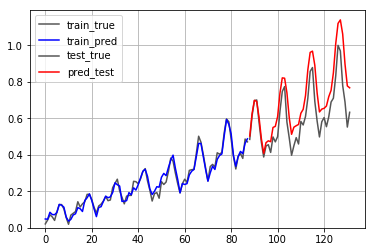

In [34]:
PRED_N = 300
model_ar = AR(train)
model_ar = model_ar.fit(disp=True)

pred_train = model_ar.predict(start=model_ar.k_ar, end=len(train)-1)
pred_test = model_ar.predict(start=len(train), end=len(train)+len(test)-1)

print('Params:', model_ar.params)
show_result(train, test, pred_train, pred_test, lag=model_ar.k_ar)

## Using Least square Estimation


In [52]:
ols = sm.OLS(train[LAG+1:], sm.add_constant(ts_train)[:-1], )
ols = ols.fit()
display(ols.summary())

def predict_with_ols(ols, x, length):
    h = np.ones(x.shape[0] + 1)
    h[1:] = x
    
    response = list()
    for _ in range(length):
        p = ols.predict(h)
        h[1:-1] = h[2:]
        h[-1] = p
        response.append(p)
    response = np.array(response)
    return response

train_pred = ols.predict(sm.add_constant(ts_train))
test_pred = predict_with_ols(ols, ts_train[-1], length=len(test))

show_result(train, test, train_pred, test_pred, lag=LAG)

ValueError: endog and exog matrices are different sizes

## Using Polynomial Curve Fitting

과거 12개 데이터를 통해서 그 다음을 예측합니다.

In [51]:
np.sum( (test_pred - test)**2)/len(test)

0.0087566707067374266

POLY: [ 1.12606145  0.03206947]
Lag Value: 12
Train R^2: 0.964235587521
Train MSE: 0.00334382046089
Test  R^2: 0.597946720219
Test  MSE: 0.00875667070674


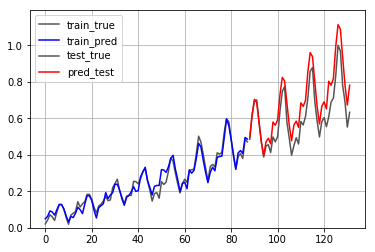

In [35]:
DEGREE = 1

def poly_pred(poly, x, lag, length):
    h = x
    result = list()
    
    for _ in range(math.ceil(length/lag)):
        h = np.polyval(poly, h)
        result += h.reshape(-1).tolist()
        
    result = np.array(result[:length])
    return result

def show_result(train: np.array, test: np.array, train_pred: np.array, test_pred: np.array, lag: int):
    x_train = np.arange(len(train_pred))
    x_test = np.arange(len(train_pred), len(train_pred) + len(test_pred))

    pylab.ylim(np.min(train), np.max(test) + np.std(test) * 1.3)
    pylab.plot(x_train, train[lag:], linestyle="-", label='train_true', color="#555555")
    pylab.plot(x_train, train_pred, label='train_pred', color='blue')
    pylab.plot(x_test, test, label='test_true', color='#555555')
    pylab.plot(x_test, test_pred, label='pred_test', color='red')
    pylab.legend()
    pylab.grid()
    
    print('Lag Value:', lag)
    print('Train R^2:', r2_score(train[lag:], train_pred))
    print('Train MSE:', mean_squared_error(train[:-lag], train_pred))
    print('Test  R^2:', r2_score(test, test_pred))
    print('Test  MSE:', mean_squared_error(test, test_pred))

poly = np.polyfit(train[:-LAG], train[LAG:], DEGREE)
train_pred = np.polyval(poly, train[:-LAG])
test_pred = poly_pred(poly, train[-LAG:], lag=LAG, length=len(test)) # np.polyval(poly, train[-LAG:])

print('POLY:', poly)
show_result(train, test, train_pred, test_pred, lag=LAG)